### Load Jupyter Notebook magic

In [1]:
%matplotlib inline
%load_ext watermark

In [2]:
import cf_units
import datetime
import iris
import matplotlib as mpl
import matplotlib.patheffects as PathEffects
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import numpy as np
import os
import xray
#
import sattools as st
import umtools.utils as umu
from faamtools import core
from faamtools.avaps import read_avaps_nc
#
import map_plot_func as mymap
import mypaths
import plot_params as pp
import misc_utils as misc

In [3]:
%watermark -u -d -m -v -p numpy,matplotlib,iris,xray,sattools,umtools,faamtools

last updated: 2016-08-15 

CPython 3.5.2
IPython 5.0.0

numpy 1.10.4
matplotlib 1.5.2
iris 1.9.2
xray 0.7.0
sattools 0.1
umtools 0.1.5
faamtools 0.2.3

compiler   : GCC 4.8.2 20140120 (Red Hat 4.8.2-15)
system     : Linux
release    : 3.13.0-93-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit


### MetUM data

In [4]:
iris.FUTURE.netcdf_promote = True
fcst_ref = '25_1200'
um_res_ctrl = umu.grdstep('km2p2')
um_res_hires = umu.grdstep('km0p5')

In [5]:
surf_alt_ctrl = iris.load_cube(os.path.join(mypaths.extdir, 'UM', 'exp_results', um_res_ctrl.key, fcst_ref, 'obs', 'umnsa_surf*023*'),
                               'surface_altitude')
surf_alt_hires = iris.load_cube(os.path.join(mypaths.extdir, 'UM', 'exp_results', um_res_hires.key, fcst_ref, 'obs', 'umnsa_surf*023*'),
                               'surface_altitude')

In [6]:
lon2d_ctrl, lat2d_ctrl = umu.unrotate_xy_grids(surf_alt_ctrl)
print(lon2d_ctrl.shape, lon2d_ctrl.min(), lon2d_ctrl[lon2d_ctrl.shape[0]//2,lon2d_ctrl.shape[1]//2], lon2d_ctrl.max())
print(lat2d_ctrl.shape, lat2d_ctrl.min(), lat2d_ctrl[lat2d_ctrl.shape[0]//2,lat2d_ctrl.shape[1]//2], lat2d_ctrl.max())

(600, 600) -22.7870363545 11.0 44.6974493436
(600, 600) 68.1741172644 75.0 80.9799995422


In [7]:
lon2d_hires, lat2d_hires = umu.unrotate_xy_grids(surf_alt_hires)
print(lon2d_hires.shape, lon2d_hires.min(), lon2d_hires[lon2d_hires.shape[0]//2,lon2d_hires.shape[1]//2], lon2d_hires.max())
print(lat2d_hires.shape, lat2d_hires.min(), lat2d_hires[lat2d_hires.shape[0]//2,lat2d_hires.shape[1]//2], lat2d_hires.max())

(1000, 1000) -1.37735517153 8.0 17.3589092178
(1000, 1000) 71.6149970535 74.0 76.2454996109


### Observations

In [8]:
faam = core.read_core_nc(mypaths.faamf, time2datetime=True)

In [9]:
AB = range(0,11)
ds = [read_avaps_nc(mypaths.ds_flist[i], time2datetime=True) for i in AB]

long_ds = [ds[i].lon.fil[1] for i in AB]
lati_ds = [ds[i].lat.fil[1] for i in AB]

In [10]:
fl_seg = core.parse_profiles_runs_info(os.path.join(mypaths.faamdir, 'sawtooth_summary.txt'), daystr='20130326')

extra_points = []
for iseg in fl_seg[1:5]:
    i_end = np.argmin([abs(i.total_seconds()) for i in faam.time.val - datetime.datetime.strptime(iseg[2], '%Y%m%d%H%M%S')])
    extra_points.append(dict(lon=faam.lon.val[i_end], lat=faam.lat.val[i_end]))
    
extra_points = [dict(name=chr(i), **j) for i, j in zip(range(65, 91), extra_points)]
extra_points[0]['lon'] += 1
extra_points[0]['lat'] -= 0.1
extra_points[1]['lat'] += 0.25
extra_points[1]['lon'] -= 0.5
extra_points[2]['lat'] -= 0.7
extra_points[2]['lon'] += 0.25
extra_points[3]['lat'] += 0.25
extra_points[3]['lon'] -= 0.25

### Satellite data

In [11]:
bbox = (-2.5, 10, 71, 80)

#### CloudSat

In [12]:
cldst_lons, cldst_lats, cldst_height, cldst_time, elev = st.cloudsat.geodata(mypaths.cloudsat_geoprof_flist[1], return_list=True)
ii = np.where((cldst_lons > bbox[0]) & (cldst_lons < bbox[1]) &
              (cldst_lats > bbox[2]) & (cldst_lats < bbox[3]))[0]
i1, i2 = ii[0], ii[-1]
cldst_mdt = mpl.dates.date2num(cldst_time[i1:i2])

#### AVHRR

In [13]:
nearest_avhrr = np.argmin([abs(int(cldst_time[i1].strftime('%Y%m%d%H%M')) - int(i.split('/')[-1].split('.')[0])) for i in mypaths.avhrr_flist])
avhrr_dt = datetime.datetime.strptime(mypaths.avhrr_flist[nearest_avhrr].split('/')[-1].split('.')[0], '%Y%m%d%H%M')

In [14]:
avhrr_lons, avhrr_lats, avhrr_data = st.avhrr.read_gtiff(mypaths.avhrr_flist[nearest_avhrr])

#### ASCAT

In [15]:
ascat_data = xray.open_dataset(mypaths.ascat_12km_flist[7])
ascat_lons, ascat_lats = ascat_data.lon.values, ascat_data.lat.values

In [16]:
um2ascat_gridratio = cf_units.Unit('2.2km').convert(1, cf_units.Unit(ascat_data.pixel_size_on_horizontal))
ascat_dt = ascat_data.time.values.astype('<M8[us]').astype(datetime.datetime)
ascat_mdt = mpl.dates.date2num(ascat_dt)

## Main Plot

### Plot settings: map boundaries, plot kwargs etc.

In [17]:
lon0 = 11
lat0 = 75

In [18]:
mapkw = dict(lon1=lon0-15,lon2=lon0+4,lat1=lat0-5,lat2=lat0+2,tick_incr=[5.,1.], coast=False, resolution='c')

In [19]:
sctkw = dict(vmin=0, vmax=25, edgecolors='', alpha=0.01)
cbarkw = dict(orientation='vertical')
mapkw = dict(lon1=lon0-16,lon2=lon0+35,lat1=lat0-9,lat2=lat0+6,tick_incr=[5.,1.], coast=False, resolution='c')
fmt = 'pdf'
svfigkw = dict(format=fmt, dpi=300, bbox_inches='tight')

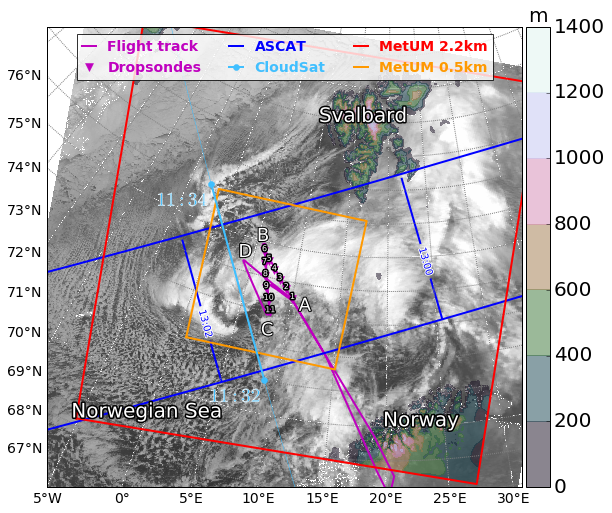

In [20]:
fig = plt.figure(figsize=(9,9))
axgrid = AxesGrid(fig, 111, nrows_ncols=(1,1), axes_pad=0.7, 
                cbar_location='right', cbar_mode='each', cbar_pad=0.05)

ax = axgrid[0]
bm = mymap.make_map(ax=ax, **mapkw)
c = bm.pcolormesh(avhrr_lons, avhrr_lats, avhrr_data, cmap='gray', rasterized=True, latlon=True)

c = bm.contourf(lon2d_ctrl, lat2d_ctrl, surf_alt_ctrl.data[0, ...], cmap=plt.cm.cubehelix, levels=np.arange(0, 1500, 200), latlon=True, alpha=0.5)
cb = plt.colorbar(c, cax=axgrid.cbar_axes[0], **cbarkw)
cb.ax.tick_params(labelsize=20)
cb.ax.set_title('m', fontsize=20)

# Flight track
bm.plot(faam.lon.val[~np.isnan(faam.lon.val)], faam.lat.val[~np.isnan(faam.lat.val)],
        linestyle='-', linewidth=2, color='m', label='Flight track', latlon=True)
# Dropsonde positions
ds_x, ds_y = bm(long_ds, lati_ds)
bm.plot(ds_x, ds_y, linestyle='None',
        marker='v', ms=8, mec='m', mfc='m',label='Dropsondes', latlon=False)
for i, j in enumerate(range(1, 12)):
    txt = ax.annotate('{}'.format(j), (ds_x[i], ds_y[i]), size=8, ha='center', color='w',
                      path_effects=[PathEffects.withStroke(linewidth=3,  foreground='k')])
    txt.set_zorder(200)

# ASCAT
s = int(max(1, 6*um2ascat_gridratio))*2
gap_ind = np.argmax(abs(np.diff(ascat_lats[0, :])))
bm.plot(ascat_lons[:, 0], ascat_lats[:, 0], linewidth=2, color='b', label='ASCAT', latlon=True)
bm.plot(ascat_lons[:, gap_ind], ascat_lats[:, gap_ind], linewidth=2, color='b', latlon=True)
cc = bm.contour(ascat_lons[:, gap_ind+1:], ascat_lats[:,gap_ind+1:], 
                ascat_mdt[:, gap_ind+1:], ascat_mdt[::60, 0],
                colors='b', linewidths=2, latlon=True)
ccl = ax.clabel(cc, inline=1, fmt=mpl.dates.DateFormatter('%H:%M'),colors='b')
plt.setp(ccl, path_effects=[PathEffects.withStroke(linewidth=2, foreground="w")])

cc = bm.contour(ascat_lons[:,:gap_ind], ascat_lats[:,:gap_ind],
                ascat_mdt[:,:gap_ind], ascat_mdt[::60,0],
                colors='b', linewidths=2, latlon=True)
ccl = ax.clabel(cc, inline=1, fmt=mpl.dates.DateFormatter('%H:%M'),colors='b')
plt.setp(ccl, path_effects=[PathEffects.withStroke(linewidth=2, foreground="w")])

# CloudSat
llstep= i2 - i1 # 60
x, y = bm(cldst_lons[i1:i2+1:llstep], cldst_lats[i1:i2+1:llstep])
x_lab, y_lab = bm(cldst_lons[i1:i2+1:llstep], cldst_lats[i1:i2+1:llstep])
x_lab = x_lab - 1e5
y_lab = y_lab - 5e4
clr = [mpl.colors.rgb2hex(i) for i in pp.cvec][5]
bm.plot(cldst_lons, cldst_lats, color=clr, linestyle='-', linewidth=0.5, latlon=True)
p = bm.plot(x, y, color=clr, linestyle='-', linewidth=2, marker='o', mec=clr, mfc=clr, zorder=100, label='CloudSat')
[bm.plot(i, j, marker=r"${}$".format(it.strftime('%H:%M')), mfc=clr, mec='w', ms=50, zorder=100) for (i,j,it) in zip(x_lab,y_lab,cldst_time[i1:i2+1:llstep])]

bm.plot(*misc.domain_corners_ll(lon2d_ctrl, lat2d_ctrl), c='r', linewidth=2, latlon=True, label='MetUM '+'2.2km')
bm.plot(*misc.domain_corners_ll(lon2d_hires, lat2d_hires), c='#ff9900', linestyle='-', linewidth=2, latlon=True, label='MetUM '+'0.5km')

l = ax.legend(loc=9, ncol=3, handlelength=1, numpoints=1, fontsize=14, framealpha=0.8)
l.get_frame().set_facecolor('w')
for color, text in zip(['m', 'm', 'b', clr, 'r', '#ff9900'], l.get_texts()):
    text.set_color(color)
    text.set_weight('bold')
mymap.label_map(ax, bm)
for p in extra_points:
    ix, iy = bm(p['lon'], p['lat'])
    ax.annotate(p['name'], (ix, iy), size=18, ha="center", color='w',
                 path_effects=[PathEffects.withStroke(linewidth=2,  foreground="k")])

fig.savefig(os.path.join('figures', 'all_obs_map.{fmt}').format(fmt=fmt), **svfigkw)